In [20]:
import pandas as pd
df = pd.read_excel(r'C:\Users\AKASH\OneDrive - iitkgp.ac.in\Documents\Downloads\online+retail\Online Retail.xlsx')


In [21]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [22]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
160418,550458,84596F,SMALL MARSHMALLOWS PINK BOWL,2,2011-04-18 13:13:00,0.83,NaN,United Kingdom
173838,551721,22196,SMALL HEART MEASURING SPOONS,3,2011-05-03 16:49:00,0.85,14711.0,United Kingdom
297830,562955,21974,SET OF 36 PAISLEY FLOWER DOILIES,5,2011-08-11 10:14:00,3.75,NaN,United Kingdom
206316,554929,23282,FOLDING BUTTERFLY MIRROR IVORY,12,2011-05-27 13:16:00,0.83,13018.0,United Kingdom
266428,560255,22960,JAM MAKING SET WITH JARS,2,2011-07-17 13:08:00,4.25,16054.0,United Kingdom


In [23]:
df = df[df['InvoiceNo'].notnull()]
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df.dropna(subset=['CustomerID'], inplace=True)

In [24]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(str)

RFM analysis

In [25]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Optional: Score each RFM feature 1–5
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,7
1,12347.0,2,7,4310.00,5,5,5,15
2,12348.0,75,4,1797.24,2,4,4,10
3,12349.0,19,1,1757.55,4,1,4,9
4,12350.0,310,1,334.40,1,1,2,4


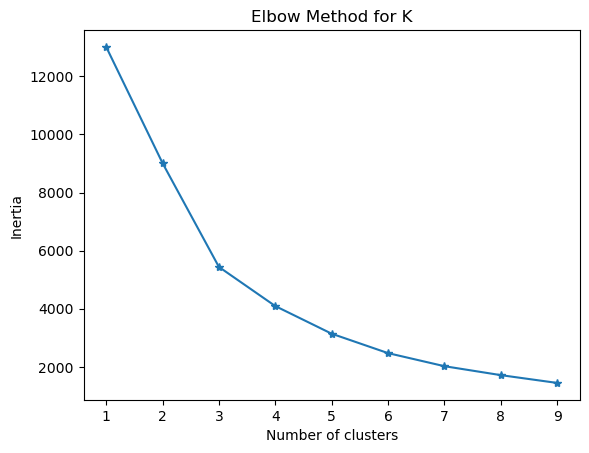

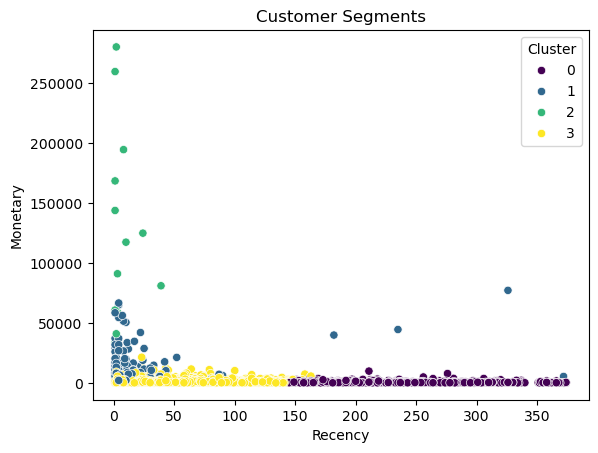

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

X = rfm[['Recency', 'Frequency', 'Monetary']]
X_scaled = StandardScaler().fit_transform(X)

# Elbow method to find optimal K
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,10), inertia, marker='*')
plt.title('Elbow Method for K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Fit KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segments')
plt.show()

In [27]:
# Aggregate features for modeling
clv_data = df.groupby('CustomerID').agg({
    'InvoiceDate': [min, max],
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
clv_data.columns = ['FirstPurchase', 'LastPurchase', 'NumOrders', 'TotalSpent']
clv_data['DaysActive'] = (clv_data['LastPurchase'] - clv_data['FirstPurchase']).dt.days
clv_data['AvgOrderValue'] = clv_data['TotalSpent'] / clv_data['NumOrders']
clv_data['CLV'] = clv_data['AvgOrderValue'] * clv_data['NumOrders']

clv_data.drop(columns=['FirstPurchase', 'LastPurchase'], inplace=True)
clv_data = clv_data[clv_data['CLV'] < clv_data['CLV'].quantile(0.95)]  # remove outliers


C:\Users\AKASH\AppData\Local\Temp\ipykernel_13976\2554818864.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  clv_data = df.groupby('CustomerID').agg({
C:\Users\AKASH\AppData\Local\Temp\ipykernel_13976\2554818864.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  clv_data = df.groupby('CustomerID').agg({


In [29]:
# Model: Predict CLV based on DaysActive, NumOrders, AvgOrderValue
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = clv_data[['DaysActive', 'NumOrders', 'AvgOrderValue']]
y = clv_data['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.8178904231490831
RMSE: 496.9626772697942


In [30]:
clv_data.head()

,NumOrders,TotalSpent,DaysActive,AvgOrderValue,CLV
CustomerID,,,,,
12347.0,7,4310.00,365,615.714286,4310.00
12348.0,4,1797.24,282,449.310000,1797.24
12349.0,1,1757.55,0,1757.550000,1757.55
12350.0,1,334.40,0,334.400000,334.40
12352.0,8,2506.04,260,313.255000,2506.04


In [33]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Cluster
0,12346.0,326,1,77183.60,1,1,5,7,1
1,12347.0,2,7,4310.00,5,5,5,15,3
2,12348.0,75,4,1797.24,2,4,4,10,3
3,12349.0,19,1,1757.55,4,1,4,9,3
4,12350.0,310,1,334.40,1,1,2,4,0
